In [30]:
import glob
import os

import numpy as np
import pandas as pd

DATA_DIR = os.path.join("..", "data")
CSV_GLOB = os.path.join(DATA_DIR, "api_data_aadhar_enrolment_*.csv")

csv_files = sorted(glob.glob(CSV_GLOB))
if not csv_files:
    raise FileNotFoundError(f"No files matched: {CSV_GLOB}")

csv_files, len(csv_files)



(['..\\data\\api_data_aadhar_enrolment_0_500000.csv',
  '..\\data\\api_data_aadhar_enrolment_1000000_1006029.csv',
  '..\\data\\api_data_aadhar_enrolment_500000_1000000.csv'],
 3)

In [31]:
# Load all chunks (memory-conscious) and standardize types

usecols = [
    "date",
    "state",
    "district",
    "pincode",
    "age_0_5",
    "age_5_17",
    "age_18_greater",
]

# Read as strings first where ambiguity exists, then coerce deterministically.
dtype = {
    "state": "string",
    "district": "string",
    "pincode": "string",
    "age_0_5": "string",
    "age_5_17": "string",
    "age_18_greater": "string",
}

frames = []
for f in csv_files:
    tmp = pd.read_csv(f, usecols=usecols, dtype=dtype)
    frames.append(tmp)

df = pd.concat(frames, ignore_index=True)
df.head()



,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [32]:
# Inspect (do not assume)
df.info(), df.isna().sum().sort_values(ascending=False).head(10)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  string
 2   district        1006029 non-null  string
 3   pincode         1006029 non-null  string
 4   age_0_5         1006029 non-null  string
 5   age_5_17        1006029 non-null  string
 6   age_18_greater  1006029 non-null  string
dtypes: object(1), string(6)
memory usage: 53.7+ MB


(None,
 date              0
 state             0
 district          0
 pincode           0
 age_0_5           0
 age_5_17          0
 age_18_greater    0
 dtype: int64)

In [33]:
# Type fixing

# date: dataset uses dd-mm-yyyy (e.g., 02-03-2025)
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")

age_cols = ["age_0_5", "age_5_17", "age_18_greater"]
for c in age_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Geography cleanup
geo_cols = ["state", "district", "pincode"]
for c in geo_cols:
    df[c] = df[c].astype("string").str.strip()

# Report parse failures before cleaning
report = {
    "rows_total": len(df),
    "date_parse_failed": int(df["date"].isna().sum()),
    "missing_state": int(df["state"].isna().sum()),
    "missing_district": int(df["district"].isna().sum()),
    "missing_pincode": int(df["pincode"].isna().sum()),
    "age_missing_any": int(df[age_cols].isna().any(axis=1).sum()),
}
report



{'rows_total': 1006029,
 'date_parse_failed': 0,
 'missing_state': 0,
 'missing_district': 0,
 'missing_pincode': 0,
 'age_missing_any': 0}

In [34]:
# Handle missing & invalid values (per documented rules)

# Drop rows with missing geography or date
before = len(df)
df_clean = df.dropna(subset=["date", "state", "district", "pincode"]).copy()

# Negative values are impossible: treat as missing
neg_mask = (df_clean[age_cols] < 0).any(axis=1)
neg_rows = int(neg_mask.sum())
if neg_rows:
    df_clean.loc[neg_mask, age_cols] = np.nan

# Fill missing age values with 0 (counts were reported above)
df_clean[age_cols] = df_clean[age_cols].fillna(0)

# Convert to integer after cleaning
for c in age_cols:
    df_clean[c] = df_clean[c].round().astype("int64")

after = len(df_clean)
{
    "dropped_rows_missing_geo_or_date": int(before - after),
    "negative_age_rows_found": neg_rows,
    "rows_remaining": int(after),
}



{'dropped_rows_missing_geo_or_date': 0,
 'negative_age_rows_found': 0,
 'rows_remaining': 1006029}

In [35]:
# Derived columns

df_clean["total_enrolments"] = df_clean["age_0_5"] + df_clean["age_5_17"] + df_clean["age_18_greater"]
df_clean["all_zero_flag"] = df_clean["total_enrolments"].eq(0)

# Monthly period for readability
df_clean["month"] = df_clean["date"].dt.to_period("M")

df_clean[["date", "month", "state", "district", "pincode", *age_cols, "total_enrolments", "all_zero_flag"]].head()



,date,month,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolments,all_zero_flag
0,2025-03-02,2025-03,Meghalaya,East Khasi Hills,793121,11,61,37,109,False
1,2025-03-09,2025-03,Karnataka,Bengaluru Urban,560043,14,33,39,86,False
2,2025-03-09,2025-03,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,False
3,2025-03-09,2025-03,Uttar Pradesh,Aligarh,202133,62,29,15,106,False
4,2025-03-09,2025-03,Karnataka,Bengaluru Urban,560016,14,16,21,51,False


In [36]:
# Monthly aggregation (state + district)

monthly_df = (
    df_clean.groupby(["month", "state", "district"], as_index=False)[age_cols + ["total_enrolments"]]
    .sum()
    .sort_values(["month", "state", "district"], ignore_index=True)
)

# Age composition features
monthly_df["child_ratio"] = (
    (monthly_df["age_0_5"] + monthly_df["age_5_17"]) / monthly_df["total_enrolments"].replace({0: np.nan})
)

monthly_df.head()



,month,state,district,age_0_5,age_5_17,age_18_greater,total_enrolments,child_ratio
0,2025-03,Andhra Pradesh,Spsr Nellore,43,44,29,116,0.750000
1,2025-03,Assam,Baksa,11,14,13,38,0.657895
2,2025-03,Assam,Barpeta,24,34,10,68,0.852941
3,2025-03,Assam,Bongaigaon,25,33,31,89,0.651685
4,2025-03,Assam,Chirang,12,29,15,56,0.732143


In [37]:
# Sanity checks (do not skip)

checks = {}

# 1) Any negatives left?
checks["negatives_remaining"] = int((df_clean[age_cols + ["total_enrolments"]] < 0).any(axis=1).sum())

# 2) All-zero rows count
checks["all_zero_rows"] = int(df_clean["all_zero_flag"].sum())

# 3) Extreme spikes (flag only): top 10 record-level totals
checks["top10_record_level_totals"] = (
    df_clean.sort_values("total_enrolments", ascending=False)[
        ["date", "state", "district", "pincode", "total_enrolments"]
    ]
    .head(10)
)

# 4) Districts that are always zero (after aggregation)
district_monthly_nonzero = (
    monthly_df.groupby(["state", "district"], as_index=False)["total_enrolments"].sum()
)
checks["districts_always_zero_count"] = int((district_monthly_nonzero["total_enrolments"] == 0).sum())

checks



{'negatives_remaining': 0,
 'all_zero_rows': 0,
 'top10_record_level_totals':            date           state          district pincode  total_enrolments
 2976 2025-07-01   Uttar Pradesh         Moradabad  244001              3965
 3213 2025-07-01     Maharashtra        Aurangabad  431001              3835
 893  2025-04-01       Meghalaya  West Khasi Hills  793119              3027
 3041 2025-07-01   Uttar Pradesh            Hardoi  241001              3006
 2446 2025-07-01   Uttar Pradesh         Firozabad  283203              2990
 3060 2025-07-01   Uttar Pradesh        Saharanpur  247001              2920
 2588 2025-07-01           Delhi  North East Delhi  110094              2874
 2250 2025-07-01  Madhya Pradesh           Barwani  451666              2855
 3069 2025-07-01   Uttar Pradesh           Aligarh  202001              2845
 2818 2025-07-01     West Bengal    Dinajpur Uttar  733210              2727,
 'districts_always_zero_count': 0}

In [38]:
import matplotlib.pyplot as plt

try:
    import seaborn as sns

    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 11



In [39]:
# Helper: convert Period to timestamp for plotting

def _month_ts(s: pd.Series) -> pd.Series:
    return s.dt.to_timestamp()

national_monthly = (
    df_clean.groupby("month", as_index=False)[age_cols + ["total_enrolments"]].sum().sort_values("month")
)
national_monthly["month_ts"] = _month_ts(national_monthly["month"])

state_monthly = (
    df_clean.groupby(["month", "state"], as_index=False)[age_cols + ["total_enrolments"]].sum().sort_values(["month", "state"])
)
state_monthly["month_ts"] = _month_ts(state_monthly["month"])

district_monthly = (
    df_clean.groupby(["month", "state", "district"], as_index=False)[age_cols + ["total_enrolments"]].sum().sort_values(["month", "state", "district"])
)
district_monthly["month_ts"] = _month_ts(district_monthly["month"])

pincode_monthly = (
    df_clean.groupby(["month", "state", "district", "pincode"], as_index=False)[age_cols + ["total_enrolments"]].sum().sort_values(["month", "state", "district", "pincode"])
)
pincode_monthly["month_ts"] = _month_ts(pincode_monthly["month"])

national_monthly.head()



,month,age_0_5,age_5_17,age_18_greater,total_enrolments,month_ts
0,2025-03,5367,7407,3808,16582,2025-03-01
1,2025-04,141154,91371,24913,257438,2025-04-01
2,2025-05,95342,71690,16584,183616,2025-05-01
3,2025-06,98943,99911,16880,215734,2025-06-01
4,2025-07,318352,263333,35183,616868,2025-07-01


### 3.2 Univariate analysis

#### 3.2.1 Total enrolments over time (national)
A simple monthly line chart to detect growth, stability, and demand spikes.



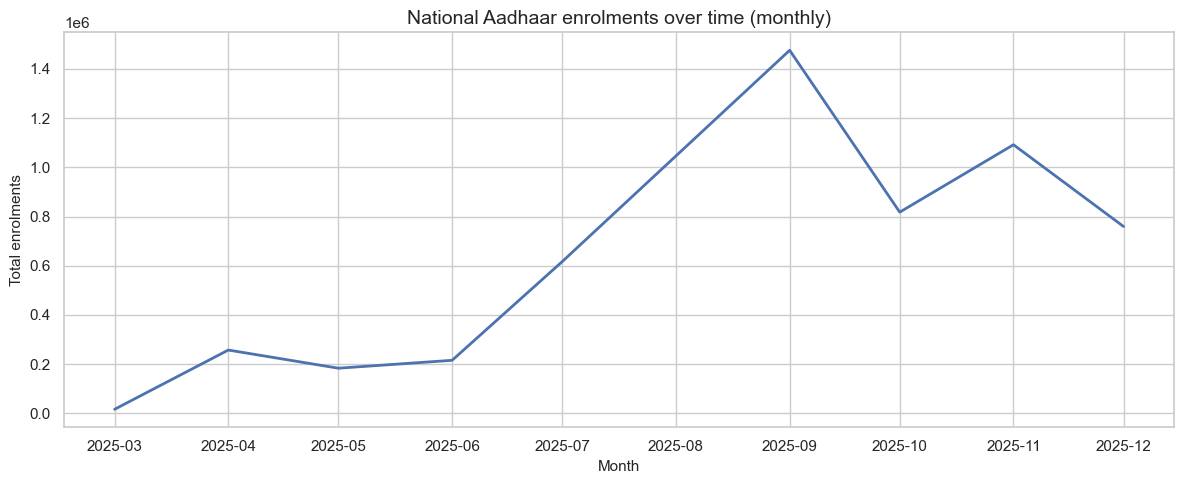

In [40]:
plt.figure()
plt.plot(national_monthly["month_ts"], national_monthly["total_enrolments"], linewidth=2)
plt.title("National Aadhaar enrolments over time (monthly)")
plt.xlabel("Month")
plt.ylabel("Total enrolments")
plt.tight_layout()
plt.show()



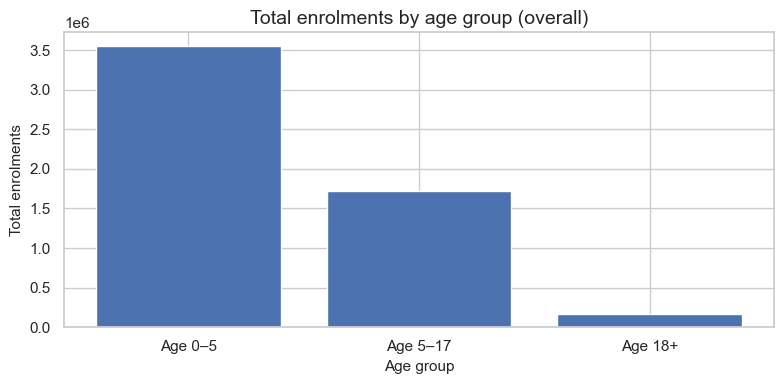

In [41]:
age_totals = national_monthly[age_cols].sum().rename(
    {
        "age_0_5": "Age 0–5",
        "age_5_17": "Age 5–17",
        "age_18_greater": "Age 18+",
    }
)

plt.figure(figsize=(8, 4))
plt.bar(age_totals.index, age_totals.values)
plt.title("Total enrolments by age group (overall)")
plt.xlabel("Age group")
plt.ylabel("Total enrolments")
plt.tight_layout()
plt.show()



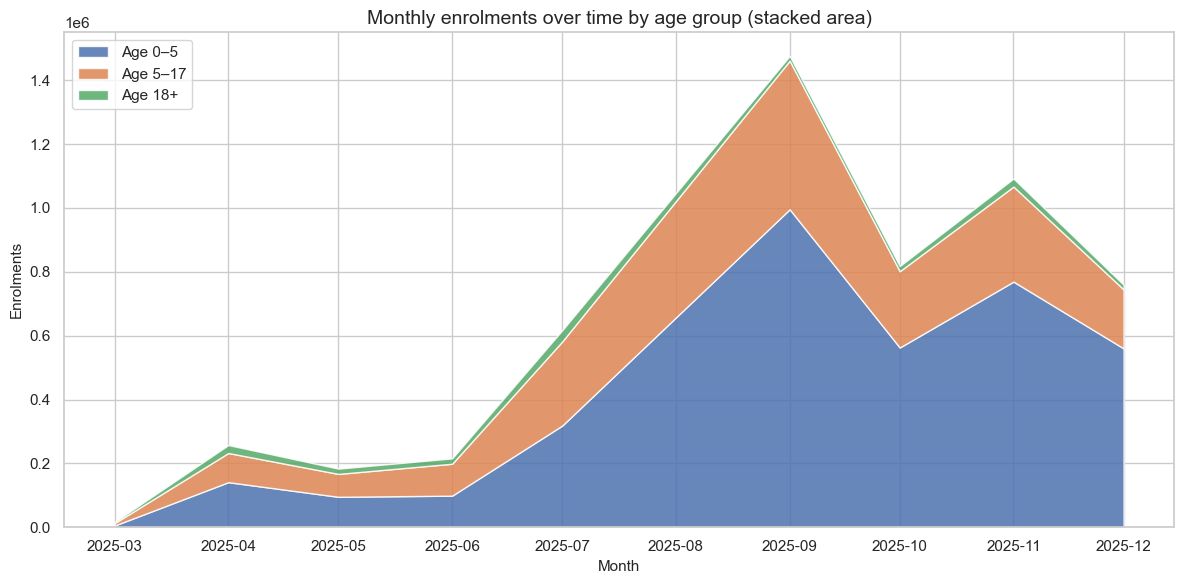

In [42]:
x = national_monthly["month_ts"]
series = [national_monthly["age_0_5"], national_monthly["age_5_17"], national_monthly["age_18_greater"]]
labels = ["Age 0–5", "Age 5–17", "Age 18+"]

plt.figure(figsize=(12, 6))
plt.stackplot(x, series, labels=labels, alpha=0.85)
plt.title("Monthly enrolments over time by age group (stacked area)")
plt.xlabel("Month")
plt.ylabel("Enrolments")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()



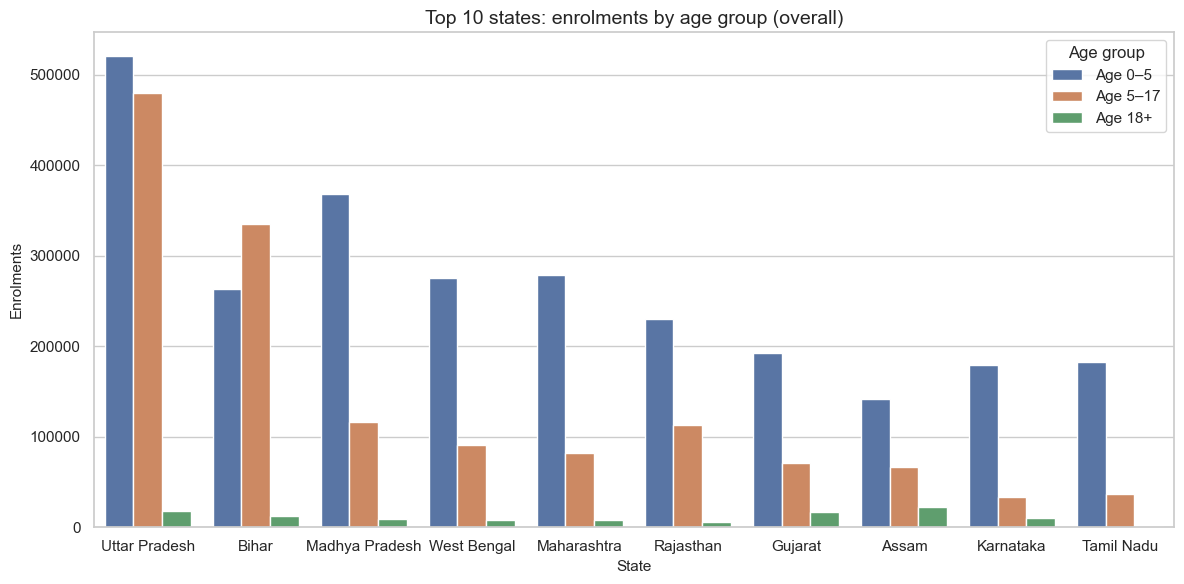

In [43]:
state_totals = (
    df_clean.groupby("state", as_index=False)[age_cols + ["total_enrolments"]].sum().sort_values("total_enrolments", ascending=False)
)

top_states = state_totals.head(10).copy()
plot_df = top_states.melt(id_vars=["state"], value_vars=age_cols, var_name="age_group", value_name="enrolments")
plot_df["age_group"] = plot_df["age_group"].map(
    {"age_0_5": "Age 0–5", "age_5_17": "Age 5–17", "age_18_greater": "Age 18+"}
)

plt.figure(figsize=(12, 6))
if sns is not None:
    # Order states by total enrolments (highest to lowest) for planning-friendly comparison
    state_order = top_states["state"].tolist()
    sns.barplot(data=plot_df, x="state", y="enrolments", hue="age_group", order=state_order)
else:
    # fallback: simple grouped bars
    states = top_states["state"].tolist()
    idx = np.arange(len(states))
    w = 0.25
    plt.bar(idx - w, top_states["age_0_5"], width=w, label="Age 0–5")
    plt.bar(idx, top_states["age_5_17"], width=w, label="Age 5–17")
    plt.bar(idx + w, top_states["age_18_greater"], width=w, label="Age 18+")
    plt.xticks(idx, states, rotation=45, ha="right")

plt.title("Top 10 states: enrolments by age group (overall)")
plt.xlabel("State")
plt.ylabel("Enrolments")
plt.legend(title="Age group")
plt.tight_layout()
plt.show()



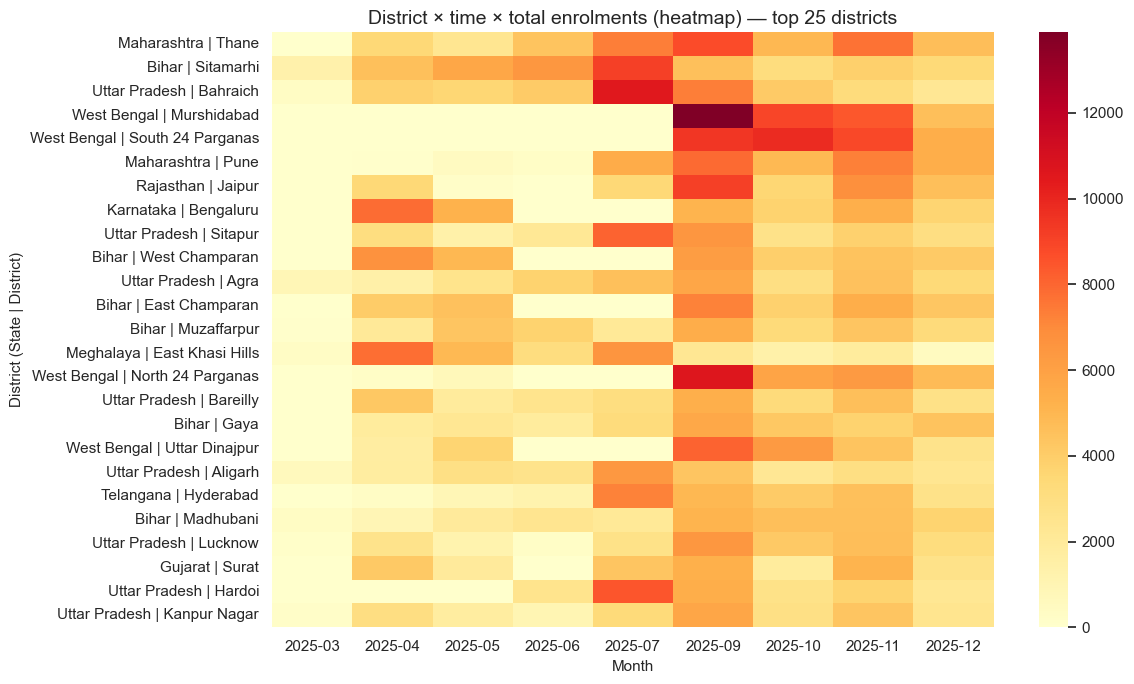

In [51]:
# Build a stable district key for plotting (state + district)
district_monthly2 = district_monthly.copy()
district_monthly2["district_key"] = district_monthly2["state"].astype(str) + " | " + district_monthly2["district"].astype(str)

top_districts = (
    district_monthly2.groupby("district_key", as_index=False)["total_enrolments"].sum()
    .sort_values("total_enrolments", ascending=False)
    .head(25)["district_key"]
    .tolist()
)

heat_df = district_monthly2[district_monthly2["district_key"].isin(top_districts)].copy()
pivot = heat_df.pivot_table(
    index="district_key", columns="month", values="total_enrolments", aggfunc="sum", fill_value=0
)

# Tighten ordering: months in chronological order, districts by overall volume (highest to lowest)
if hasattr(pivot.columns, "sort_values"):
    pivot = pivot.reindex(pivot.columns.sort_values(), axis=1)
else:
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

row_order = pivot.sum(axis=1).sort_values(ascending=False).index
pivot = pivot.reindex(row_order)

# Slightly smaller heatmap for a more compact layout
plt.figure(figsize=(12, 7))
if sns is not None:
    sns.heatmap(pivot, cmap="YlOrRd")
else:
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="Total enrolments")
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xticks(np.arange(len(pivot.columns)), [str(m) for m in pivot.columns], rotation=45, ha="right")

plt.title("District × time × total enrolments (heatmap) — top 25 districts")
plt.xlabel("Month")
plt.ylabel("District (State | District)")
plt.tight_layout()
plt.show()



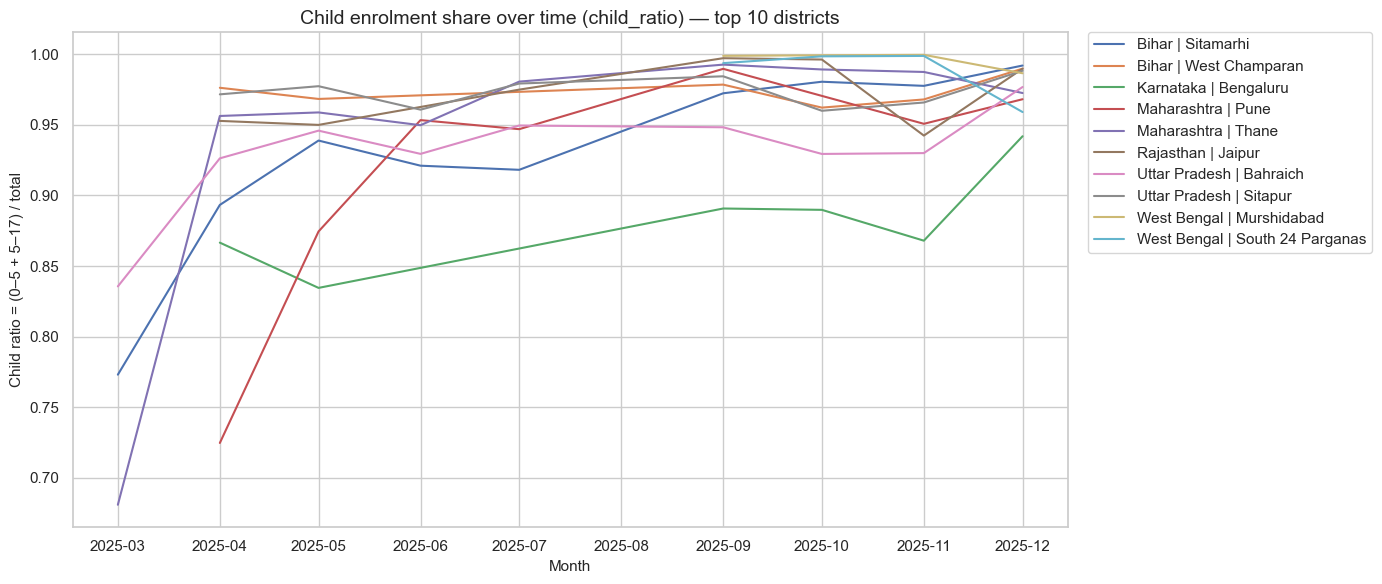

In [46]:
district_monthly_ratio = district_monthly2.copy()
district_monthly_ratio["child_ratio"] = (
    (district_monthly_ratio["age_0_5"] + district_monthly_ratio["age_5_17"]) / district_monthly_ratio["total_enrolments"].replace({0: np.nan})
)

top10 = (
    district_monthly_ratio.groupby("district_key", as_index=False)["total_enrolments"].sum()
    .sort_values("total_enrolments", ascending=False)
    .head(10)["district_key"]
    .tolist()
)

plot_ratio = district_monthly_ratio[district_monthly_ratio["district_key"].isin(top10)].copy()
plot_ratio = plot_ratio.sort_values(["district_key", "month_ts"])

plt.figure(figsize=(14, 6))
if sns is not None:
    sns.lineplot(data=plot_ratio, x="month_ts", y="child_ratio", hue="district_key")
else:
    for k, g in plot_ratio.groupby("district_key"):
        plt.plot(g["month_ts"], g["child_ratio"], label=k)

plt.title("Child enrolment share over time (child_ratio) — top 10 districts")
plt.xlabel("Month")
plt.ylabel("Child ratio = (0–5 + 5–17) / total")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()



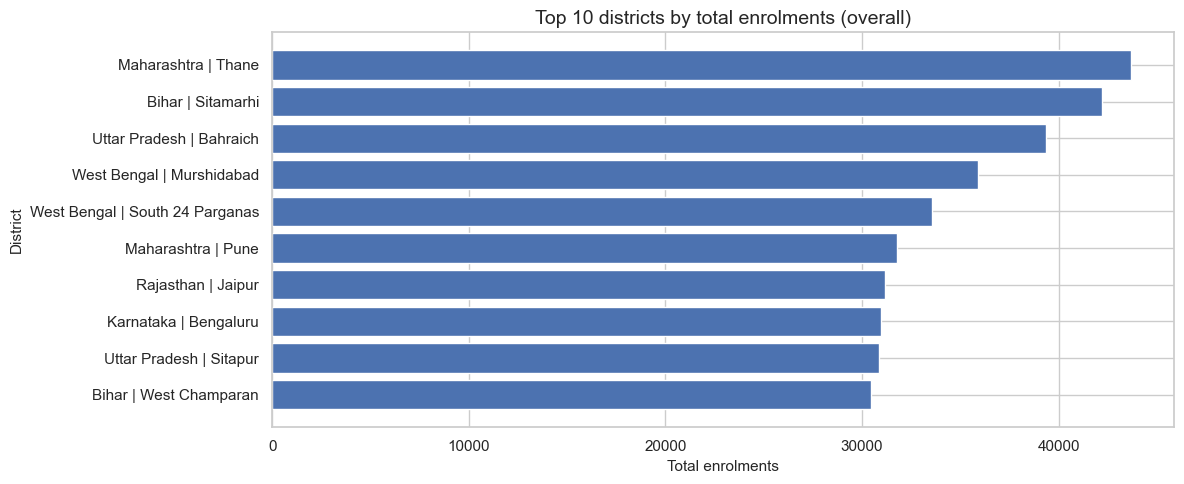

,state,district,total_enrolments,district_key
572,Maharashtra,Thane,43688,Maharashtra | Thane
160,Bihar,Sitamarhi,42232,Bihar | Sitamarhi
909,Uttar Pradesh,Bahraich,39338,Uttar Pradesh | Bahraich
1043,West Bengal,Murshidabad,35911,West Bengal | Murshidabad
1056,West Bengal,South 24 Parganas,33540,West Bengal | South 24 Parganas
563,Maharashtra,Pune,31763,Maharashtra | Pune
770,Rajasthan,Jaipur,31146,Rajasthan | Jaipur
397,Karnataka,Bengaluru,30980,Karnataka | Bengaluru
982,Uttar Pradesh,Sitapur,30854,Uttar Pradesh | Sitapur
164,Bihar,West Champaran,30438,Bihar | West Champaran


In [47]:
top10_districts_tbl = (
    df_clean.groupby(["state", "district"], as_index=False)["total_enrolments"].sum().sort_values("total_enrolments", ascending=False).head(10)
)

top10_districts_tbl["district_key"] = top10_districts_tbl["state"].astype(str) + " | " + top10_districts_tbl["district"].astype(str)

plt.figure(figsize=(12, 5))
plt.barh(top10_districts_tbl["district_key"][::-1], top10_districts_tbl["total_enrolments"][::-1])
plt.title("Top 10 districts by total enrolments (overall)")
plt.xlabel("Total enrolments")
plt.ylabel("District")
plt.tight_layout()
plt.show()

top10_districts_tbl



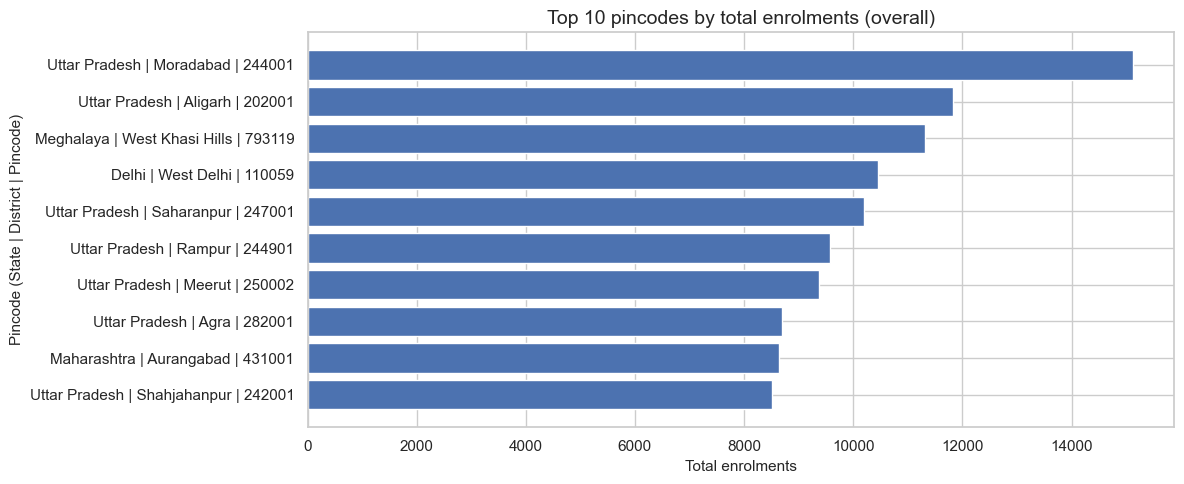

,state,district,pincode,total_enrolments,pincode_key
25635,Uttar Pradesh,Moradabad,244001,15122,Uttar Pradesh | Moradabad | 244001
23992,Uttar Pradesh,Aligarh,202001,11833,Uttar Pradesh | Aligarh | 202001
15955,Meghalaya,West Khasi Hills,793119,11321,Meghalaya | West Khasi Hills | 793119
5650,Delhi,West Delhi,110059,10462,Delhi | West Delhi | 110059
25832,Uttar Pradesh,Saharanpur,247001,10189,Uttar Pradesh | Saharanpur | 247001
25825,Uttar Pradesh,Rampur,244901,9572,Uttar Pradesh | Rampur | 244901
25587,Uttar Pradesh,Meerut,250002,9378,Uttar Pradesh | Meerut | 250002
23963,Uttar Pradesh,Agra,282001,8686,Uttar Pradesh | Agra | 282001
13886,Maharashtra,Aurangabad,431001,8645,Maharashtra | Aurangabad | 431001
25925,Uttar Pradesh,Shahjahanpur,242001,8511,Uttar Pradesh | Shahjahanpur | 242001


In [48]:
top10_pincodes_tbl = (
    df_clean.groupby(["state", "district", "pincode"], as_index=False)["total_enrolments"]
    .sum()
    .sort_values("total_enrolments", ascending=False)
    .head(10)
)

top10_pincodes_tbl["pincode_key"] = (
    top10_pincodes_tbl["state"].astype(str)
    + " | "
    + top10_pincodes_tbl["district"].astype(str)
    + " | "
    + top10_pincodes_tbl["pincode"].astype(str)
)

plt.figure(figsize=(12, 5))
plt.barh(top10_pincodes_tbl["pincode_key"][::-1], top10_pincodes_tbl["total_enrolments"][::-1])
plt.title("Top 10 pincodes by total enrolments (overall)")
plt.xlabel("Total enrolments")
plt.ylabel("Pincode (State | District | Pincode)")
plt.tight_layout()
plt.show()

top10_pincodes_tbl



In [49]:
import os
import glob

import numpy as np
import pandas as pd
import plotly.express as px

# Make this cell runnable even after kernel restart.
# If df_clean/age_cols aren't defined yet, we (re)create them from the raw CSVs.
if "age_cols" not in globals():
    age_cols = ["age_0_5", "age_5_17", "age_18_greater"]

if "df_clean" not in globals():
    # If an earlier cell already created df, reuse it; otherwise load from disk.
    if "df" not in globals():
        DATA_DIR = os.path.join("..", "data")
        CSV_GLOB = os.path.join(DATA_DIR, "api_data_aadhar_enrolment_*.csv")
        csv_files = sorted(glob.glob(CSV_GLOB))
        if not csv_files:
            raise FileNotFoundError(
                f"No enrolment CSV files found at {CSV_GLOB}. Run the data-loading cells above or check your ../data folder."
            )

        usecols = ["date", "state", "district", "pincode"] + age_cols
        dtype = {
            "state": "string",
            "district": "string",
            "pincode": "string",
            "age_0_5": "string",
            "age_5_17": "string",
            "age_18_greater": "string",
        }

        frames = [pd.read_csv(f, usecols=usecols, dtype=dtype) for f in csv_files]
        df = pd.concat(frames, ignore_index=True)

    # Minimal, consistent cleaning (matches notebook rules)
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
    for c in age_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    for c in ["state", "district", "pincode"]:
        df[c] = df[c].astype("string").str.strip()

    df_clean = df.dropna(subset=["date", "state", "district", "pincode"]).copy()

    neg_mask = (df_clean[age_cols] < 0).any(axis=1)
    if int(neg_mask.sum()):
        df_clean.loc[neg_mask, age_cols] = np.nan

    df_clean[age_cols] = df_clean[age_cols].fillna(0)
    for c in age_cols:
        df_clean[c] = df_clean[c].round().astype("int64")

    df_clean["total_enrolments"] = df_clean["age_0_5"] + df_clean["age_5_17"] + df_clean["age_18_greater"]

# Approximate state/UT centroids (lat, lon) for visualisation only
STATE_CENTROIDS = {
    "Andhra Pradesh": (15.9129, 79.74),
    "Arunachal Pradesh": (28.2180, 94.7278),
    "Assam": (26.2006, 92.9376),
    "Bihar": (25.0961, 85.3131),
    "Chhattisgarh": (21.2787, 81.8661),
    "Goa": (15.2993, 74.1240),
    "Gujarat": (22.2587, 71.1924),
    "Haryana": (29.0588, 76.0856),
    "Himachal Pradesh": (31.1048, 77.1734),
    "Jharkhand": (23.6102, 85.2799),
    "Karnataka": (15.3173, 75.7139),
    "Kerala": (10.8505, 76.2711),
    "Madhya Pradesh": (22.9734, 78.6569),
    "Maharashtra": (19.7515, 75.7139),
    "Manipur": (24.6637, 93.9063),
    "Meghalaya": (25.4670, 91.3662),
    "Mizoram": (23.1645, 92.9376),
    "Nagaland": (26.1584, 94.5624),
    "Odisha": (20.9517, 85.0985),
    "Punjab": (31.1471, 75.3412),
    "Rajasthan": (27.0238, 74.2179),
    "Sikkim": (27.5330, 88.5122),
    "Tamil Nadu": (11.1271, 78.6569),
    "Telangana": (18.1124, 79.0193),
    "Tripura": (23.9408, 91.9882),
    "Uttar Pradesh": (26.8467, 80.9462),
    "Uttarakhand": (30.0668, 79.0193),
    "West Bengal": (22.9868, 87.8550),
    "Delhi": (28.7041, 77.1025),
    "Jammu and Kashmir": (33.2778, 75.3412),
    "Ladakh": (34.1526, 77.5770),
    "Puducherry": (11.9416, 79.8083),
    "Chandigarh": (30.7333, 76.7794),
    "Andaman and Nicobar Islands": (11.7401, 92.6586),
    "Lakshadweep": (10.5667, 72.6417),
    "Dadra and Nagar Haveli and Daman and Diu": (20.1809, 73.0169),
}

state_summary = (
    df_clean.groupby("state", as_index=False)[age_cols + ["total_enrolments"]]
    .sum()
    .sort_values("total_enrolments", ascending=False)
)

state_summary["child_ratio"] = (
    (state_summary["age_0_5"] + state_summary["age_5_17"]) / state_summary["total_enrolments"].replace({0: np.nan})
)

state_summary["lat"] = state_summary["state"].map(lambda s: STATE_CENTROIDS.get(str(s), (np.nan, np.nan))[0])
state_summary["lon"] = state_summary["state"].map(lambda s: STATE_CENTROIDS.get(str(s), (np.nan, np.nan))[1])

map_df = state_summary.dropna(subset=["lat", "lon"]).copy()

# Use a real tile basemap for a more realistic map (no Mapbox token needed)
fig = px.scatter_mapbox(
    map_df,
    lat="lat",
    lon="lon",
    size="total_enrolments",
    color="total_enrolments",
    hover_name="state",
    hover_data={"total_enrolments": ":,", "child_ratio": ":.2f"},
    # Darker palette for more contrast on the basemap
    color_continuous_scale=[
        [0.0, "#0b1220"],
        [0.5, "#1e3a8a"],
        [1.0, "#1d4ed8"],
    ],
    size_max=28,
    zoom=4.2,
    center={"lat": 22.5, "lon": 79.0},
    title="Where enrolment demand is concentrated (state-level bubble map)",
    height=480,
)

# Make dots darker/more legible: higher opacity
fig.update_traces(marker=dict(opacity=0.9))

fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=50, b=0),
)

fig.show()



C:\Users\chowd\AppData\Local\Temp\ipykernel_35600\1027620100.py:114: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # needed for 3D plots


C:\Users\chowd\AppData\Local\Temp\ipykernel_35600\157297844.py:55: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



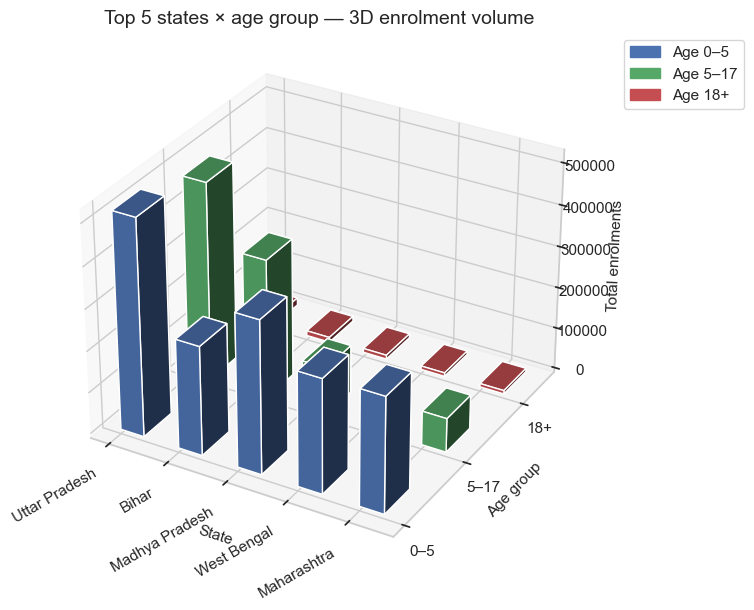

In [50]:
# Prepare data for 3D bar chart: Top 5 states × 3 age groups

state_age_totals = (
    df_clean.groupby("state", as_index=False)[age_cols + ["total_enrolments"]]
    .sum()
    .sort_values("total_enrolments", ascending=False)
)

top5_states = state_age_totals.head(5).reset_index(drop=True)

states = top5_states["state"].tolist()
ages = ["age_0_5", "age_5_17", "age_18_greater"]
age_labels = ["0–5", "5–17", "18+"]
colors = ["#4c72b0", "#55a868", "#c44e52"]  # blue, green, red

# Build coordinates
xs = []  # state index
ys = []  # age index
zs = []  # bar height
cs = []  # colour

for i, st in enumerate(states):
    for j, age_col in enumerate(ages):
        xs.append(i)
        ys.append(j)
        zs.append(top5_states.loc[i, age_col])
        cs.append(colors[j])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Width/depth of bars
_dx = 0.4
_dy = 0.4

ax.bar3d(xs, ys, [0] * len(zs), _dx, _dy, zs, color=cs, shade=True)

ax.set_xticks(range(len(states)))
ax.set_xticklabels(states, rotation=30, ha="right")
ax.set_xlabel("State")

ax.set_yticks(range(len(age_labels)))
ax.set_yticklabels(age_labels)
ax.set_ylabel("Age group")

ax.set_zlabel("Total enrolments")
ax.set_title("Top 5 states × age group — 3D enrolment volume")

# Simple legend using proxy artists
from matplotlib.patches import Patch

legend_patches = [Patch(color=c, label=lbl) for c, lbl in zip(colors, ["Age 0–5", "Age 5–17", "Age 18+"])]
ax.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

